In [105]:
import sys
sys.path.append("..")
import functools
import pickle

import numpy as np
import scipy.interpolate
import scipy.signal
import matplotlib.pyplot as plt
import torch
import pyequion2

import tmcdiff

In [106]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
TK = 298.15
bulk_velocity = 1e0
pipe_diameter = 1e-2
c_nahco3 = 0.018
c_cacl2 = 0.006
c_nacl = 0.003
c_mgcl2 = [0.0, 0.006, 0.012, 0.024]
ngrid = 20
ypmax = 5
def load_solver(c_mgcl2, loadname):
    molal_balance = {'C':c_nahco3,
                     'Ca':c_cacl2,
                     'Na':c_nahco3 + c_nacl,
                     'Cl':2*c_cacl2 + c_nacl + 2*c_mgcl2,
                     'Mg': c_mgcl2}
    species = ["C", "Ca", "Na", "Cl", "Mg"]
    phases = ["Calcite", "Dolomite"]
    kreac = np.array([0.0522, 0.0261])
    if c_mgcl2 == 0.0:
        phases = phases[:-1]
        species = species[:-1]
        kreac = kreac[:-1]
        molal_balance.pop("Mg")
    solver = tmcdiff.TransportSolver(species)
    solver.kreaction = kreac
    solver.set_flow_conditions(TK, bulk_velocity, pipe_diameter)
    solver.set_initial_conditions(molal_balance, phases)
    solver.build_transport(ngrid, ypmax)
#     solver.set_initial_guess()
    solver.load(loadname)
    return solver

In [108]:
solver0 = load_solver(0.0, "data/exp3_0")
solver1 = load_solver(0.06, "data/exp3_6")
solver2 = load_solver(0.12, "data/exp3_12")
solver3 = load_solver(0.12, "data/exp3_24")

In [109]:
def make_logsatur_and_dmdt(solver):
    logg = solver.builder.activity_model_func(np.exp(np.moveaxis(solver.logc, -2, -1)), numpy=True)
    logg = np.moveaxis(logg, -2, -1)
    loga = logg + solver.logc
    nu = solver.builder.reduced_reaction_vector.numpy()
    logiap = np.einsum("ij, ljm -> lim", nu, loga)
    logsatur = logiap - solver.builder.logk_solid[..., None].numpy()
    dmdt_molm2s = solver.builder.reaction_function(torch.tensor(logsatur[:, :, 0]).T).T.numpy() #mol/m2s
    dmdt_gm2s = dmdt_molm2s*np.array([100.0869, 184.4008][:dmdt_molm2s.shape[-1]]) #g/m2 s
    dmdt_gms = dmdt_gm2s*(np.pi*pipe_diameter)
    dmdt_gmh = dmdt_gms*3600
    return logsatur, dmdt_gmh

In [110]:
logsatur, dmdt_gmh = make_logsatur_and_dmdt(solver0)

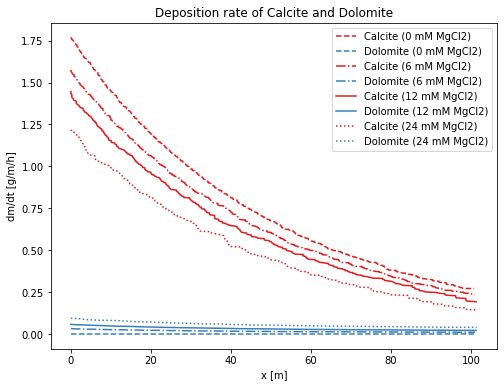

In [111]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("Set1")
linestyles = ["--", "-.", "-", ":"]
jlabels = [0, 6, 12, 24]
for j, solver in enumerate([solver0, solver1, solver2, solver3]):
    logsatur, dmdt_gmh = make_logsatur_and_dmdt(solver)
    linestyle = linestyles[j]
    for i, phase in enumerate(solver.builder.phases):
        y = scipy.signal.savgol_filter(dmdt_gmh[:, i], 51, 3)
        plt.plot(solver.t*bulk_velocity, y,
                 label=f"{phase} ({jlabels[j]} mM MgCl2)", linestyle=linestyle,
                 color=cmap(i))
    if 'Dolomite' not in solver.builder.phases:
        phase = 'Dolomite'
        dolomite_dummy = np.zeros_like(y)
        plt.plot(solver.t*bulk_velocity, dolomite_dummy,
                 label=f"{phase} ({jlabels[j]} mM MgCl2)", linestyle=linestyle,
                 color=cmap(i+1))
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("dm/dt [g/m/h]")
plt.title("Deposition rate of Calcite and Dolomite")
plt.savefig("plots/exp2_dmdt.pdf", dpi=600)

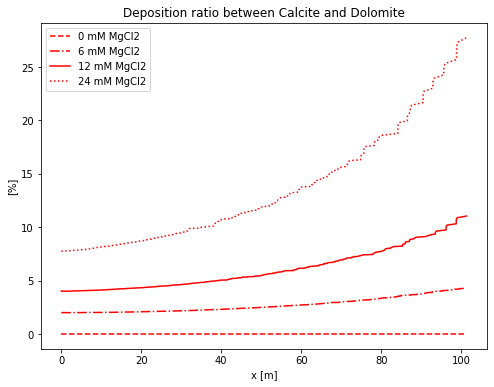

In [112]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("Set1")
linestyles = ["--", "-.", "-", ":"]
for j, solver in enumerate([solver0, solver1, solver2, solver3]):
    logsatur, dmdt_gmh = make_logsatur_and_dmdt(solver)
    linestyle = linestyles[j]
    dmdt_calcite = dmdt_gmh[:, 0]
    dmdt_dolemite = np.zeros_like(dmdt_calcite) if dmdt_gmh.shape[-1] == 1 else dmdt_gmh[:, 1]
    ratio = dmdt_dolemite/dmdt_calcite
    ratio = scipy.signal.savgol_filter(ratio, 51, 3)*100
    plt.plot(solver.t*bulk_velocity, ratio, label=f"{jlabels[j]} mM MgCl2", linestyle=linestyle,
             color='red')
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("[%]")
plt.title("Deposition ratio between Calcite and Dolomite")
plt.savefig("plots/exp2_dmdt_ratio.pdf", dpi=600)

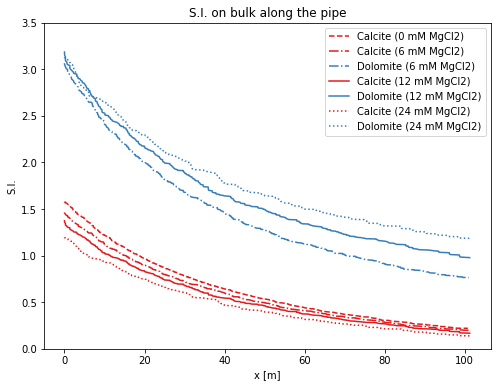

In [113]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("Set1")
linestyles = ["--", "-.", "-", ":"]
for j, solver in enumerate([solver0, solver1, solver2, solver3]):
    logsatur, dmdt_gmh = make_logsatur_and_dmdt(solver)
    linestyle = linestyles[j]
    for i, phase in enumerate(solver.builder.phases):
        y = scipy.signal.savgol_filter(logsatur[:, i, -1]/np.log(10), 51, 3)
        plt.plot(solver.t*bulk_velocity, y,
                 label=f"{phase} ({jlabels[j]} mM MgCl2)", linestyle=linestyle,
                 color=cmap(i))
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("S.I.")
plt.ylim(bottom=0.0,top=3.5)
plt.title("S.I. on bulk along the pipe")
plt.savefig("plots/exp2_si_bulk.pdf", dpi=600)

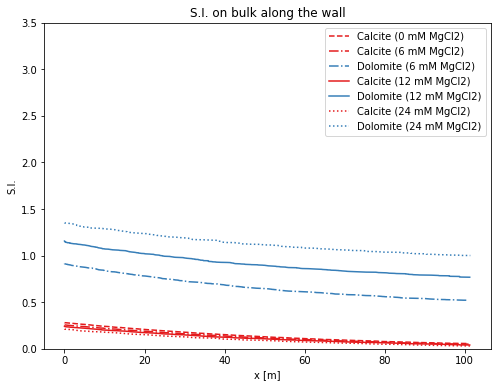

In [114]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("Set1")
linestyles = ["--", "-.", "-", ":"]
for j, solver in enumerate([solver0, solver1, solver2, solver3]):
    logsatur, dmdt_gmh = make_logsatur_and_dmdt(solver)
    linestyle = linestyles[j]
    for i, phase in enumerate(solver.builder.phases):
        y = scipy.signal.savgol_filter(logsatur[:, i, 0]/np.log(10), 51, 3)
        plt.plot(solver.t*bulk_velocity, y,
                 label=f"{phase} ({jlabels[j]} mM MgCl2)", linestyle=linestyle,
                 color=cmap(i))
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("S.I.")
plt.ylim(bottom=0.0,top=3.5)
plt.title("S.I. on bulk along the wall")
plt.savefig("plots/exp2_si_wall.pdf", dpi=600)